In [1]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Subset
from torch.optim import SGD

import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from scipy.stats import beta

In [2]:
INPUT_SIZE = 784
NUM_LAYERS = 2
NUM_HIDDEN_UNITS = 64
OUTPUT_SIZE = 10

NUM_EPOCHS = 10
BATCH_SIZE = 250
LEARNING_RATE = 0.1
MOMENTUM = 0.9

NUM_UNDERLYING_DISTRIBUTION = 60000

In [3]:
DATASET = torchvision.datasets.MNIST(root='../data', train=True, transform=transforms.ToTensor(), download=True)

INDEX_UNDERLYING=list(range(NUM_UNDERLYING_DISTRIBUTION))
SUBSET_UNDERLYING=Subset(DATASET, INDEX_UNDERLYING)
LOADER_UNDERLYING=DataLoader(dataset=SUBSET_UNDERLYING, batch_size=BATCH_SIZE, shuffle=False)

In [4]:
class NeuralNet(nn.Module):
    def __init__(self, input_size, num_layers, hidden_size, output_size):
        super(NeuralNet, self).__init__()
        self.hidden = nn.ModuleList()
        self.input_layer = nn.Linear(input_size, hidden_size)
        for k in range(num_layers-1):
            self.hidden.append(nn.Linear(hidden_size, hidden_size))
        self.output_layer = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        x=self.input_layer(x)
        x=x.relu()
        for layer in self.hidden:
            x=layer(x)
            x=x.relu()
        x=self.output_layer(x)
        return x
    
def ReLU_glorot_init(model):
    torch.manual_seed(1)
    for name, param in model.named_parameters():
        if name.endswith(".bias"):
            param.data.fill_(0)
        else:
            nn.init.xavier_normal_(param)

In [5]:
def get_bound(num_samples, eta, zeta, gamma, alpha, delta):
    index_sample=np.random.choice(INDEX_UNDERLYING, num_samples, replace=False)
    index_other, index_approx=train_test_split(index_sample, test_size=eta)
    index_train, index_empirical_error=train_test_split(index_other, test_size=zeta)
    index_train_full, index_empirical_error_full=train_test_split(index_sample, test_size=zeta)

    num_approx=len(index_approx)
    num_empirical_error=len(index_empirical_error)
    num_empirical_error_full=len(index_empirical_error_full)
    num_train=len(index_train)
    num_train_full=len(index_train_full)
    
    subset_train=Subset(SUBSET_UNDERLYING, index_train)
    subset_train_full=Subset(SUBSET_UNDERLYING, index_train_full)
    subset_empirical_error=Subset(SUBSET_UNDERLYING, index_empirical_error)
    subset_empirical_error_full=Subset(SUBSET_UNDERLYING, index_empirical_error_full)

    loader_train = DataLoader(dataset=subset_train, batch_size=BATCH_SIZE, shuffle=True)
    loader_train_full = DataLoader(dataset=subset_train_full, batch_size=BATCH_SIZE, shuffle=True)
    loader_empirical_error = DataLoader(dataset=subset_empirical_error, batch_size=BATCH_SIZE, shuffle=False)
    loader_empirical_error_full = DataLoader(dataset=subset_empirical_error_full, batch_size=BATCH_SIZE, shuffle=False)

    model_region = NeuralNet(INPUT_SIZE, NUM_LAYERS, NUM_HIDDEN_UNITS, OUTPUT_SIZE)
    model_point = NeuralNet(INPUT_SIZE, NUM_LAYERS, NUM_HIDDEN_UNITS, OUTPUT_SIZE)
    ReLU_glorot_init(model_region)
    ReLU_glorot_init(model_point)

    criterion = nn.CrossEntropyLoss()
    optimizer_region = SGD(model_region.parameters(), lr=LEARNING_RATE, momentum=MOMENTUM)
    optimizer_point = SGD(model_point.parameters(), lr=LEARNING_RATE, momentum=MOMENTUM)

    for epoch in range(NUM_EPOCHS):
        for images, labels in loader_train:
            images = images.reshape(-1, INPUT_SIZE)
            outputs = model_region(images)
            loss = criterion(outputs, labels)
            optimizer_region.zero_grad()
            loss.backward()
            optimizer_region.step()
        #print('Epoch {}: Loss {:.3f}'.format(epoch+1,loss.item()))

    for epoch in range(NUM_EPOCHS):
        for images, labels in loader_train_full:
            images = images.reshape(-1, INPUT_SIZE)
            outputs = model_point(images)
            loss = criterion(outputs, labels)
            optimizer_point.zero_grad()
            loss.backward()
            optimizer_point.step()
        #print('Epoch {}: Loss {:.3f}'.format(epoch+1,loss.item()))

    empirical_accuracy=0
    with torch.no_grad():
        for image, label in loader_empirical_error:
            image = image.reshape(-1, INPUT_SIZE)
            output = model_region(image)
            predictions=output.max(1)[1]
            empirical_accuracy+=sum((predictions==label).tolist())
    empirical_accuracy/=num_empirical_error

    empirical_accuracy_full=0
    with torch.no_grad():
        for image, label in loader_empirical_error_full:
            image = image.reshape(-1, INPUT_SIZE)
            output = model_point(image)
            predictions=output.max(1)[1]
            empirical_accuracy_full+=sum((predictions==label).tolist())
    empirical_accuracy_full/=num_empirical_error_full

    true_accuracy_region=0
    correct_bools=[]
    with torch.no_grad():
        for image, label in LOADER_UNDERLYING:
            image = image.reshape(-1, INPUT_SIZE)
            output = model_region(image)
            predictions=output.max(1)[1]
            correct_bools+=(predictions==label).tolist()
            true_accuracy_region+=sum((predictions==label).tolist())
    true_accuracy_region/=NUM_UNDERLYING_DISTRIBUTION

    true_accuracy_point=0
    with torch.no_grad():
        for image, label in LOADER_UNDERLYING:
            image = image.reshape(-1, INPUT_SIZE)
            output = model_point(image)
            predictions=output.max(1)[1]
            true_accuracy_point+=sum((predictions==label).tolist())
    true_accuracy_point/=NUM_UNDERLYING_DISTRIBUTION

    index_verifiable=[]
    for k,correct in enumerate(correct_bools):
        if correct:
            index_verifiable.append(k)

    prop_to_sample=min(1,gamma/true_accuracy_region)
    Delta=train_test_split(index_verifiable, test_size=prop_to_sample)[1]

    p_hat=0
    for ind in index_approx:
        if ind in Delta:
            p_hat+=1
    p_hat/=num_approx
    p_Delta=len(Delta)/NUM_UNDERLYING_DISTRIBUTION
    p_L=beta.ppf(alpha,int(num_approx*p_hat),int(num_approx-num_approx*p_hat+1))

    ci_difference=p_Delta-p_L

    log_component = np.log((1-p_L+np.sqrt((1-p_L)**2+4*delta**(1/num_empirical_error)*p_L))/(2*delta**(1/num_empirical_error)))
    bound_region=(1-empirical_accuracy)+np.sqrt(log_component/2)
    bound_point=(1-empirical_accuracy_full)+np.sqrt(np.log(1/delta)/(2*num_empirical_error_full))

    return 1-true_accuracy_region, 1-true_accuracy_point, bound_region, bound_point, ci_difference, 1-(delta+alpha*(1-delta))

In [187]:
ZETA=0.3
GAMMA=0.5
ALPHA=0.025
DELTA=0.025

SAMPLE_SIZES=[1000,5000,10000]
ETAS=np.linspace(0.1,0.9,9)
N=len(SAMPLE_SIZES)

true_errors_region=[[] for n in range(N)]
true_errors_point=[[] for n in range(N)]
empirical_errors=[[] for n in range(N)]
bounds_region=[[] for n in range(N)]
bounds_point=[[] for n in range(N)]
ci_diffs=[[] for n in range(N)]

for k,sample_size in enumerate(SAMPLE_SIZES):
    for eta in ETAS:
        true_error_region, true_error_point, bound_region, bound_point, ci_diff, con = get_bound(sample_size,eta,ZETA,GAMMA,ALPHA,DELTA)
        true_errors_region[k].append(true_error_region)
        true_errors_point[k].append(true_error_point)
        bounds_region[k].append(bound_region)
        bounds_point[k].append(bound_point)
        ci_diffs[k].append(ci_diff)
        print('Sample Size {} eta {}'.format(sample_size,eta))

Sample Size 1000 eta 0.1
Sample Size 1000 eta 0.2
Sample Size 1000 eta 0.30000000000000004
Sample Size 1000 eta 0.4
Sample Size 1000 eta 0.5
Sample Size 1000 eta 0.6
Sample Size 1000 eta 0.7000000000000001
Sample Size 1000 eta 0.8
Sample Size 1000 eta 0.9
Sample Size 5000 eta 0.1
Sample Size 5000 eta 0.2
Sample Size 5000 eta 0.30000000000000004
Sample Size 5000 eta 0.4
Sample Size 5000 eta 0.5
Sample Size 5000 eta 0.6
Sample Size 5000 eta 0.7000000000000001
Sample Size 5000 eta 0.8
Sample Size 5000 eta 0.9
Sample Size 10000 eta 0.1
Sample Size 10000 eta 0.2
Sample Size 10000 eta 0.30000000000000004
Sample Size 10000 eta 0.4
Sample Size 10000 eta 0.5
Sample Size 10000 eta 0.6
Sample Size 10000 eta 0.7000000000000001
Sample Size 10000 eta 0.8
Sample Size 10000 eta 0.9


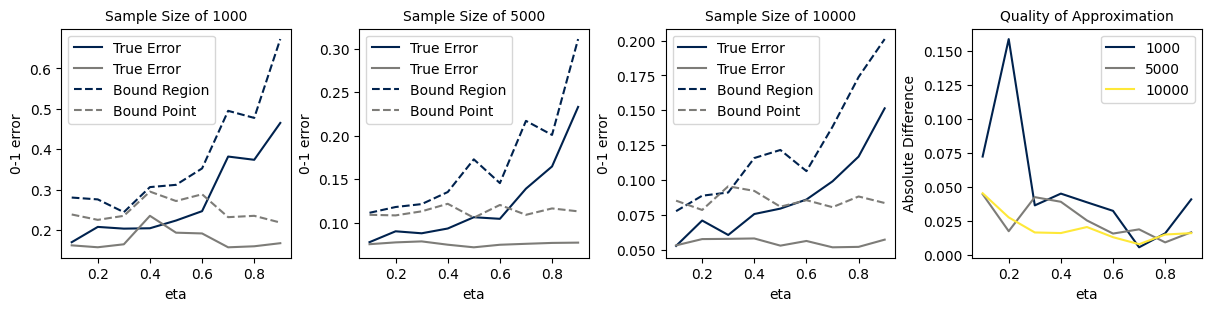

In [188]:
fig, axs = plt.subplots(1,len(SAMPLE_SIZES)+1,figsize=(12,3),layout='constrained')
colors = plt.cm.cividis(np.linspace(0, 1, 3))
for i, ax in enumerate(axs):
    if i<N:
        ax.plot(ETAS, true_errors_region[i], label='True Error', c=colors[0])
        ax.plot(ETAS, true_errors_point[i], label='True Error', c=colors[1])
        ax.plot(ETAS, bounds_region[i], label='Bound Region', c=colors[0], linestyle='dashed')
        ax.plot(ETAS, bounds_point[i], label='Bound Point', c=colors[1], linestyle='dashed')
        ax.set_xlabel('eta')
        ax.set_ylabel('0-1 error')
        ax.set_title('Sample Size of {}'.format(SAMPLE_SIZES[i]), fontsize=10)
        ax.legend()
    else:
        for k, ci_diff in enumerate(ci_diffs):
            ax.plot(ETAS, ci_diff, label=SAMPLE_SIZES[k], c=colors[k])
            ax.set_xlabel('eta')
            ax.set_ylabel('Absolute Difference')
            ax.set_title('Quality of Approximation', fontsize=10)
        ax.legend()
plt.savefig('plots/MNIST_Zeta_03.png')

In [6]:
ZETA=0.3
GAMMA=0.8
ALPHA=0.025
DELTA=0.025

SAMPLE_SIZES=[10000]
ETAS=np.linspace(0.01,0.1,9)
N=len(SAMPLE_SIZES)

true_errors_region=[[] for n in range(N)]
true_errors_point=[[] for n in range(N)]
empirical_errors=[[] for n in range(N)]
bounds_region=[[] for n in range(N)]
bounds_point=[[] for n in range(N)]
ci_diffs=[[] for n in range(N)]

for k,sample_size in enumerate(SAMPLE_SIZES):
    for eta in ETAS:
        true_error_region, true_error_point, bound_region, bound_point, ci_diff, con = get_bound(sample_size,eta,ZETA,GAMMA,ALPHA,DELTA)
        true_errors_region[k].append(true_error_region)
        true_errors_point[k].append(true_error_point)
        bounds_region[k].append(bound_region)
        bounds_point[k].append(bound_point)
        ci_diffs[k].append(ci_diff)
        print('Sample Size {} eta {}'.format(sample_size,eta))

Sample Size 10000 eta 0.01
Sample Size 10000 eta 0.02125
Sample Size 10000 eta 0.0325
Sample Size 10000 eta 0.043750000000000004
Sample Size 10000 eta 0.05500000000000001
Sample Size 10000 eta 0.06625
Sample Size 10000 eta 0.0775
Sample Size 10000 eta 0.08875000000000001
Sample Size 10000 eta 0.1


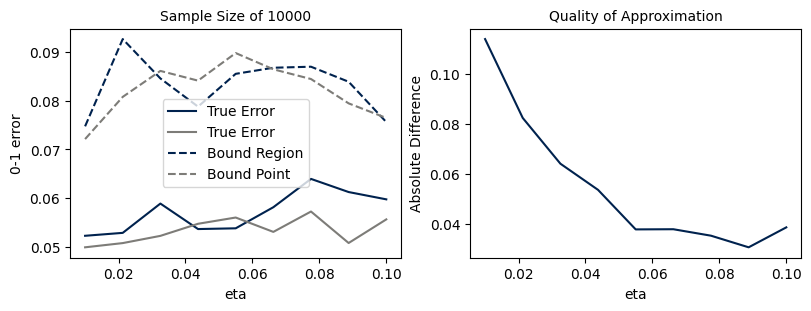

In [14]:
fig, axs = plt.subplots(1,len(SAMPLE_SIZES)+1,figsize=(8,3),layout='constrained')
colors = plt.cm.cividis(np.linspace(0, 1, 3))
for i, ax in enumerate(axs):
    if i<N:
        ax.plot(ETAS, true_errors_region[i], label='True Error', c=colors[0])
        ax.plot(ETAS, true_errors_point[i], label='True Error', c=colors[1])
        ax.plot(ETAS, bounds_region[i], label='Bound Region', c=colors[0], linestyle='dashed')
        ax.plot(ETAS, bounds_point[i], label='Bound Point', c=colors[1], linestyle='dashed')
        ax.set_xlabel('eta')
        ax.set_ylabel('0-1 error')
        ax.set_title('Sample Size of {}'.format(SAMPLE_SIZES[i]), fontsize=10)
        ax.legend()
    else:
        for k, ci_diff in enumerate(ci_diffs):
            ax.plot(ETAS, ci_diff, c=colors[k])
            ax.set_xlabel('eta')
            ax.set_ylabel('Absolute Difference')
            ax.set_title('Quality of Approximation', fontsize=10)  
plt.savefig('plots/MNIST_Zeta_03_focused.png')